In [13]:
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.extmath import cartesian
from scipy.linalg import block_diag

In [14]:
import argparse
parser = argparse.ArgumentParser(description='Process some integers.')
parser.add_argument('-f') # jupyter
parser.add_argument('--n_documents', type=int, default=10,
                   help='number of documents to collect data for')
args = parser.parse_args()
n_articles = args.n_documents

In [15]:
# n_articles = 100

In [16]:
%load_ext rpy2.ipython

In [17]:
%%R -i n_articles
library(tidyverse)
library(Hmisc)
library(ggthemes)

/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

  warnings.warn(x, RRuntimeWarning)
/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0

  warnings.warn(x, RRuntimeWarning)
/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)
/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntime

# Distances between sentences

In [18]:
# load embeddings and metadata and
# compute distances between sentences
def get_distances(model, dataset):
    input_matrix_file = "data/%s/%s_%s_%d.npy" %(dataset, dataset, model, n_articles)
    input_data_file = "data/%s/%s_reformatted_%d.csv" %(dataset, dataset, n_articles)
    # load data
    df = pd.read_csv(input_data_file)
    # load embeddings
    embeddings = np.load(input_matrix_file)
    distances = 1 - cosine_similarity(embeddings)
    displacements = embeddings[1:] - embeddings[:-1]
    return df, distances, displacements

df, distances, displacements = get_distances("skipthoughts", "wiki")

## Within vs across documents

How similar do sentences from the same document tend to be? How similar do sentences from different documents tend to be?

The similarity due to being in the same document gives us some sense of overall topic similarity.

Take any two unique sentences in the dataset, either from the same document or different documents, and measure the distance between them.

In [19]:
distances.shape

(996, 996)

In [24]:
def make_block(N):
    x = np.ones((N, N), dtype=bool)
    return x

# computing mask should be at least as fast as cosine similarity, right?
# it is, at least for 100 docs
def get_doc_masks(df, distances, mask_id="doc_id", diff_mask=True):
    number_of_sentences_per_doc = df.groupby(mask_id).apply(lambda x: len(x.s_id))
    document_blocks = number_of_sentences_per_doc.apply(make_block)
    same_doc_mask = block_diag(*document_blocks)
    if diff_mask:
        diff_doc_mask = np.logical_not(same_doc_mask)
    # upper diagonals, so we ignore same sentences
    same_doc_mask = np.triu(same_doc_mask, 1)
    if diff_mask:
        diff_doc_mask = np.triu(diff_doc_mask, 1)
        return same_doc_mask, diff_doc_mask
    else:
        return same_doc_mask

def make_df_from_distances(labeled_arrays):
    unique_labels = list(labeled_arrays.keys())
    distance_arrays = list(labeled_arrays.values())
    labels = np.repeat(unique_labels, [len(da) for da in distance_arrays])
    distances = np.concatenate(distance_arrays)
    return pd.DataFrame({"pair_type": labels, "distance": distances})
   
def within_vs_across_docs(df):
    # are they (different sentences and) in the same document?
    same_doc, diff_doc = get_doc_masks(df, distances)
    # mask by whether distances are in the same document
    same_doc = distances[same_doc]
    diff_doc = distances[diff_doc]
    # create dataframe
    doc_dist_df = make_df_from_distances({"Same Document": same_doc, "Different Document": diff_doc})
    doc_dist_means = doc_dist_df.groupby("pair_type").mean()
    return doc_dist_means, doc_dist_df

doc_dist_means, doc_dist_df = within_vs_across_docs(df)
doc_dist_means

,distance
pair_type,
Different Document,0.421016
Same Document,0.397848


/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


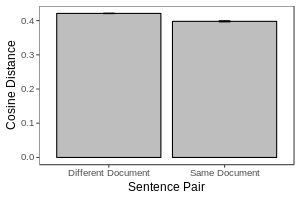

In [21]:
%%R -i doc_dist_df -w 300 -h 200 -u px
p = doc_dist_df %>%
ggplot(aes(x = pair_type, y = distance)) +
stat_summary(fun.y = mean, geom = "bar", fill = "gray", colour = "black") +
stat_summary(fun.data = mean_cl_boot, geom = "errorbar", colour="black", width = 0.1) +
ylab("Cosine Distance") +
xlab("Sentence Pair") +
theme_few(12)
print(p)
ggsave(paste("within_vs_across_documents", n_articles, ".png", sep=""))

In [22]:
# sanity check that nothing is in the same doc *and* a different doc
same_doc, diff_doc = get_doc_masks(df, distances)
assert(np.sum((same_doc == diff_doc) & (same_doc != 0)) == 0)

In [23]:
# from scipy import stats
# stats.ttest_ind(doc_dist_df[doc_dist_df['pair_type']=='Same Document']['distance'],
#                 doc_dist_df[doc_dist_df['pair_type']=='Different Document']['distance'], equal_var=False)

## Within-paragraphs

How does the distances between two unique sentences in the same paragraph vary as a function of how far apart they are in the paragraph?

How far from the first sentence is each subsequent sentence in the paragraph?

In [11]:
# find separations between sentences in corpus
sentence_pair_indices = cartesian((df.s_id,df.s_id))
start_s_id = sentence_pair_indices[:,0]
end_s_id = sentence_pair_indices[:,1]
sentence_separation = end_s_id - start_s_id
sentence_separation.shape = distances.shape
sentence_separation = sentence_separation.astype(float)
start_s_id.shape = distances.shape
end_s_id.shape = distances.shape

# get same document mask
same_doc = get_doc_masks(df, distances, "doc_id", diff_mask=False)
# filter to only unique sentences in the same paragraph
sentence_separation = sentence_separation[same_doc]
increments = distances[same_doc]
start_s_id = start_s_id[same_doc]
end_s_id = end_s_id[same_doc]

# add paragraph length column
number_of_sentences_per_par = df.groupby(within).apply(lambda x: len(x.s_id))
par_length_blocks = number_of_sentences_per_par.apply(lambda x: x*np.ones((x, x), dtype=bool))
shared_par_lengths = block_diag(*par_length_blocks)
shared_par_lengths = shared_par_lengths[same_par]

increments_df = pd.DataFrame({"sentence_separation": sentence_separation,
                              "distance":increments,
                              "sec_lengths": shared_par_lengths,
                              "start_s_id": start_s_id,
                              "end_s_id": end_s_id})

increments_df['sec_separation'] = (increments_df.sentence_separation /
                                   (increments_df.sec_lengths - 1))

increments_df

## Distances between adjacent sentences

Here's where we start talking about trajectories, at least to some extent. What's the pacing throughout the discourse? When do we make bigger or smaller moves through sentence vector space?

Position in the paragraph might affect the distance between adjacent sentences:
* accross a paragraph boundary (last of one paragraph, first of next)
* paragraph-internal
* first two sentences
* last two sentences

In [ ]:
def get_same_par_mask(df, distances):
    # pairs of indices
    product = cartesian((df.par_id,df.par_id))
    # are they in the same document?
    same_doc_mask = product[:,0] == product[:,1]
    same_doc_mask.shape = distances.shape
    return same_doc_mask

def get_first_mask(df, distances):
    # pairs of indices
    product = cartesian((df.s_in_par,df.s_in_par))
    # are they first?
    first_mask = product[:,0] == 0
    first_mask.shape = distances.shape
    return first_mask

def is_last_in_par(i, df):
    if (i == (df.shape[0]-1)):
        return True
    else:
        # next sentence is a different paragraph
        return df.par_id[i+1] != df.par_id[i]
    
def get_last_mask(df, distances):
    product = cartesian((df.s_id,df.s_id))
    last_mask = np.array([is_last_in_par(i, df) for i in product[:,1]])
    last_mask.shape = distances.shape
    return last_mask

def within_vs_across_par(df, distances, details = False):
    product = cartesian((df.s_id,df.s_id))
    adjacent = (product[:,1] - product[:,0]) == 1
    adjacent.shape = distances.shape
    
    # mask to get adjacent sentences in the same document
    adjacent = np.multiply(get_same_doc_mask(df, distances), adjacent)
    
    # mask to get adjacent sentences in the same paragraph
    same_par_mask = get_same_par_mask(df, distances)
    within_par_mask = np.multiply(same_par_mask, adjacent)
    within_par_distances = distances[within_par_mask == 1]
    across_par_mask = np.multiply(1 - same_par_mask, adjacent)
    across_par_distances = distances[across_par_mask == 1]
    
    # TODO make this more faster
    if (details):
    
        # mask to get adjacent sentences in the same paragraph:
        #     - at the beginning of the paragraph
        #     - in the middle of the paragraph
        #     - at the end of the paragraph
        first_mask = get_first_mask(df, distances)
        last_mask = get_last_mask(df, distances)
        internal_mask = (1 - (first_mask + last_mask))
        first_mask = np.multiply(first_mask, within_par_mask)
        internal_mask = np.multiply(internal_mask, within_par_mask)
        last_mask = np.multiply(last_mask, within_par_mask)
        first_distances = distances[first_mask == 1]
        internal_distances = distances[internal_mask == 1]
        last_distances = distances[last_mask == 1]
        
        pair_types = (["Within Paragraph (First)" for i in range(len(first_distances))] +
                      ["Within Paragraph (Internal)" for i in range(len(internal_distances))] +
                      ["Within Paragraph (Last)" for i in range(len(last_distances))] +
                      ["Across Paragraphs" for i in range(len(across_par_distances))])
        distances = np.concatenate((first_distances,
                                    internal_distances,
                                    last_distances,
                                    across_par_distances), axis=None)
    else:
        pair_types = (["Within Paragraph" for i in range(len(within_par_distances))] +
                      ["Across Paragraphs" for i in range(len(across_par_distances))])
        distances = np.concatenate((within_par_distances, across_par_distances), axis=None)

    # create dataframe
    par_dist_df = pd.DataFrame({"pair_type": pair_types,
                                "distance": distances})
    # get means
    par_dist_means = par_dist_df.groupby("pair_type").mean()
    
    return par_dist_means, par_dist_df

par_dist_means, par_dist_df = within_vs_across_par(df, distances)
par_dist_means

In [ ]:
# for within paragraph sentences, could be:
#     - paragraph-internal
#     - first two sentences
#     - last two sentences

par_details_dist_means, par_details_dist_df = within_vs_across_par(df, distances, details = True)
par_details_dist_means

In [ ]:
par_details_dist_df
dataset = "wiki"
model = "skipthoughts"
distances_matrix_filename = "data/%s/distances_%s_%s_%d.npy" %(dataset, dataset, model, n_articles)
np.save(distances_matrix_filename, par_details_dist_df)

## R visualization

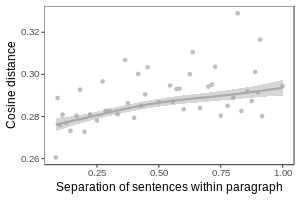

In [209]:
%%R -i increments_df -w 300 -h 200 -u px

p = increments_df %>%
group_by(par_lengths) %>%
mutate(approx_n_pars = length(start_s_id)/(par_lengths[1])) %>%
as.data.frame %>%
filter(approx_n_pars > 100) %>%
ggplot(., aes(x = par_separation, y = distance)) +
stat_summary(fun.y = mean, geom = "point", colour = "gray") +
# geom_point(alpha=1/10) +
stat_smooth(colour="darkgray") +
theme_few() +
ylab("Cosine distance") +
xlab("Separation of sentences within paragraph") +
# facet_wrap(~par_lengths) +
theme_few(12)
print(p)
ggsave(paste("within_par_decay_", n_articles, ".png", sep=""))

/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


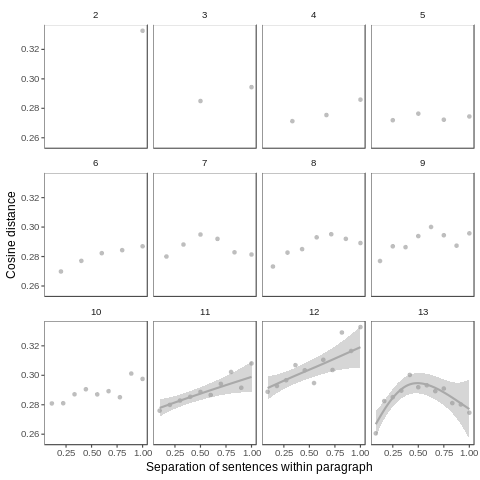

In [210]:
%%R

p = increments_df %>%
group_by(par_lengths) %>%
mutate(approx_n_pars = length(start_s_id)/(par_lengths[1])) %>%
as.data.frame %>%
filter(approx_n_pars > 100) %>%
ggplot(., aes(x = par_separation, y = distance)) +
stat_summary(fun.y = mean, geom = "point", colour = "gray") +
# geom_point(alpha=1/10) +
stat_smooth(colour="darkgray") +
theme_few() +
ylab("Cosine distance") +
xlab("Separation of sentences within paragraph") +
facet_wrap(~par_lengths) +
theme_few(12)
print(p)
ggsave(paste("within_par_decay_facetted_", n_articles, ".png", sep=""))

In [182]:
%%R
increments_df %>% filter(sentence_separation < 0.01)

[1] sentence_separation distance            par_lengths        
[4] start_s_id          end_s_id            par_separation     
<0 rows> (or 0-length row.names)


In [148]:
%%R -i df
# increments_df %>%
# filter(distance < 0.0001)

print((df %>% filter(s_id == 887))$sentence)
print((df %>% filter(s_id == 890))$sentence)

[1] "@ 6 m ) ."
[1] "@ 6 m ) ."


In [48]:
%%R -i doc_dist_means
doc_dist_means

/home/erindb/miniconda2/envs/dod/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


                    distance
Different Document 0.4210159
Same Document      0.3978477


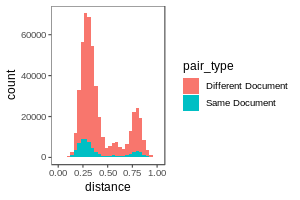

In [50]:
%%R -i doc_dist_df -w 300 -h 200 -u px
p = doc_dist_df %>%
ggplot(aes(x = distance, fill = pair_type)) +
geom_histogram(bins=30) +
theme_few(12)
print(p)
ggsave(paste("within_vs_across_documents_density_", n_articles, ".png", sep=""))

In [12]:
%%R -i doc_dist_df -w 300 -h 200 -u px
p = doc_dist_df %>%
ggplot(aes(x = pair_type, y = distance)) +
stat_summary(fun.y = mean, geom = "bar", fill = "gray", colour = "black") +
stat_summary(fun.data = mean_cl_boot, geom = "errorbar", colour="black", width = 0.1) +
ylab("Cosine Distance") +
xlab("Sentence Pair") +
theme_few(12)
print(p)
# ggsave("within_vs_across_documents.png")

UsageError: Cell magic `%%R` not found.


In [ ]:
# %%R -i par_dist_df -w 200 -h 200 -u px
# p = par_dist_df %>%
# ggplot(., aes(x = pair_type, y = distance)) +
# geom_hline(yintercept = doc_dist_means["Different Document", "distance"], colour="gray") +
# geom_hline(yintercept = doc_dist_means["Same Document", "distance"], colour="gray") +
# stat_summary(fun.y = mean, geom = "bar", fill="gray", colour="black") +
# stat_summary(fun.data = mean_cl_boot,
#              geom = "errorbar",
#              colour="black",
#              width=0.1) +
# ylab("Cosine Distance") +
# xlab("Sentence Pair") +
# theme_few(10)
# print(p)
# ggsave("adjacent_sentences_within_and_across_paragraphs.png")

In [ ]:
# %%R -i par_details_dist_df -w 400 -h 200 -u px
# p = par_details_dist_df %>%
# ggplot(., aes(x = pair_type, y = distance)) +
# geom_hline(yintercept = doc_dist_means["Different Document", "distance"], colour="gray") +
# geom_hline(yintercept = doc_dist_means["Same Document", "distance"], colour="gray") +
# stat_summary(fun.y = mean, geom = "bar", fill="gray", colour="black") +
# stat_summary(fun.data = mean_cl_boot,
#              geom = "errorbar",
#              colour="black",
#              width=0.1) +
# ylab("Cosine Distance") +
# xlab("Sentence Pair") +
# theme_few(10)
# print(p)
# ggsave("adjacent_sentences_more_details.png")